## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFRobertaModel

import pytz
import datetime

/Users/cabanela/anaconda3/envs/w266tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Resources Configuration

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
# What version of Python do you have?
import sys
import platform
import sklearn as sk

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.5-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.0.0
Scikit-Learn 1.2.2
GPU is available


## Functions and Constants

In [4]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

def load_data(group):
  df_train = pd.read_csv('data/' + group + '-dataset-train.csv')
  df_val = pd.read_csv('data/' + group + '-dataset-val.csv')
  df_test = pd.read_csv('data/' + group + '-dataset-test.csv')

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [5]:
MAX_SEQUENCE_LENGTH = 128

In [6]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

In [7]:
def build_bertweet_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERTweet layers
    if num_train_layers == 0:
      bertweet_model.trainable = False

    # partially freeze the first n pre-trained BERTweet layers
    else:
        for layer_num in range(num_train_layers):
            bertweet_model.roberta.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertweet model instance
    bert_out = bertweet_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load Data

In [8]:
X_train_disability, y_train_disability, X_test_disability, y_test_disability, X_val_disability, y_val_disability = load_data('disability')

In [9]:
X_train_disability[0]

"Doesn't work? How do we know? When the country is at the point of legalizing silencers, and the right of the mentally ill to own assault weapons, it's laughable to think we have ANY gun controls."

In [10]:
X_train_disability[1]

'LoL. The mental retardation of the (d)onkeys is stunning.\nThey propose the craziest whackjob laws without one regard to the Constitution.'

## Load BERTweet Model from_pretrained()

In [12]:
# For transformers v4.x+:
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
bertweet_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Metal device set to: Apple M1 Pro


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [13]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [14]:
bertweet_train_inputs_disability = tokenizing_pipeline(X_train_disability, bertweet_tokenizer)
bertweet_test_inputs_disability = tokenizing_pipeline(X_test_disability, bertweet_tokenizer)
bertweet_val_inputs_disability = tokenizing_pipeline(X_val_disability, bertweet_tokenizer)

## Calculate Class Weights for Disability

Get class weights for disability train set:

In [15]:
neg, pos = np.bincount(y_train_disability)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 12798
    Positive: 2758 (21.55% of total)

Disability Weight for class 0: 0.64
Disability Weight for class 1: 2.32


## Build Disability Model with half-frozen BERTweet layers

In [16]:
disability_model = build_bertweet_cls_model(num_train_layers=6, learning_rate=1e-5)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

In [17]:
america_la_tz = pytz.timezone('America/Los_Angeles')
start_time = datetime.datetime.now(tz=america_la_tz).isoformat()
print(str(start_time))

2023-04-11T02:06:07.500742-07:00


## Train Disability Model 

In [18]:
disability_history = disability_model.fit(bertweet_train_inputs_disability,
                                          y_train_disability,
                                          validation_data=(bertweet_val_inputs_disability, y_val_disability),
                                          batch_size=32,
                                          epochs=5,
                                          class_weight=disability_class_weight)

Epoch 1/5


2023-04-11 02:06:15.293854: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


400/400 [==============================] - 461s 1s/step - loss: 0.5743 - binary_accuracy: 0.6907 - precision: 0.3816 - recall: 0.7009 - f1_score: 0.4941 - val_loss: 0.4935 - val_binary_accuracy: 0.7732 - val_precision: 0.4783 - val_recall: 0.8333 - val_f1_score: 0.6078
Epoch 2/5
400/400 [==============================] - 449s 1s/step - loss: 0.4851 - binary_accuracy: 0.7629 - precision: 0.4686 - recall: 0.7458 - f1_score: 0.5755 - val_loss: 0.5486 - val_binary_accuracy: 0.7418 - val_precision: 0.4443 - val_recall: 0.8956 - val_f1_score: 0.5940
Epoch 3/5
400/400 [==============================] - 444s 1s/step - loss: 0.4440 - binary_accuracy: 0.7865 - precision: 0.5029 - recall: 0.7792 - f1_score: 0.6113 - val_loss: 0.5417 - val_binary_accuracy: 0.7409 - val_precision: 0.4443 - val_recall: 0.9133 - val_f1_score: 0.5978
Epoch 4/5
400/400 [==============================] - 445s 1s/step - loss: 0.4129 - binary_accuracy: 0.8011 - precision: 0.5252 - recall: 0.8024 - f1_score: 0.6348 - val_l

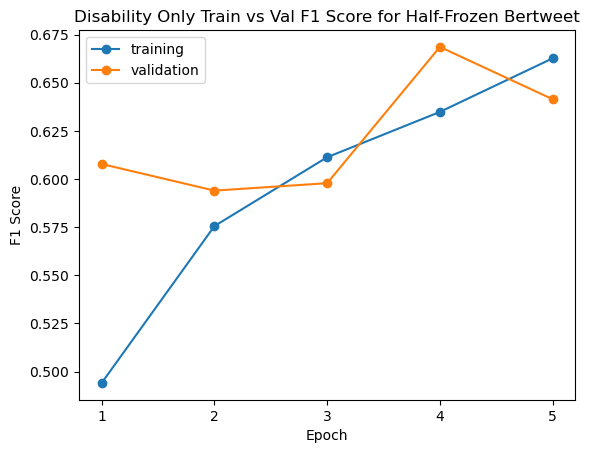

In [26]:
history = pd.DataFrame(disability_history.history)
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.title('Disability Only Train vs Val F1 Score for Half-Frozen Bertweet')
plt.xticks([0, 1, 2, 3, 4],['1', '2', '3', '4', '5'])
plt.plot(history['f1_score'], label="training", marker='o')
plt.plot(history['val_f1_score'], label="validation", marker='o')
plt.legend()
plt.show()

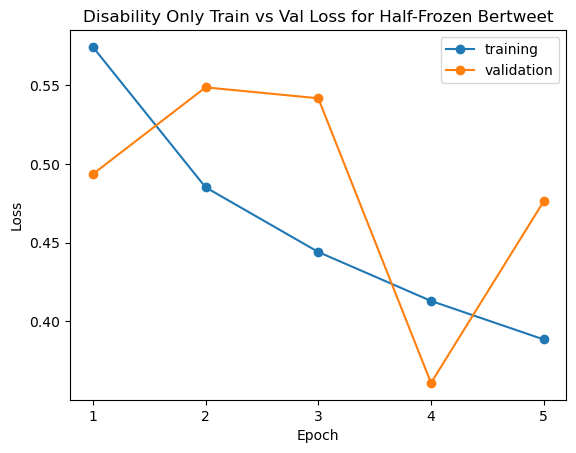

In [27]:
history = pd.DataFrame(disability_history.history)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Disability Only Train vs Val Loss for Half-Frozen Bertweet')
plt.xticks([0, 1, 2, 3, 4],['1', '2', '3', '4', '5'])
plt.plot(history['loss'], label="training", marker='o')
plt.plot(history['val_loss'], label="validation", marker='o')
plt.legend()
plt.show()

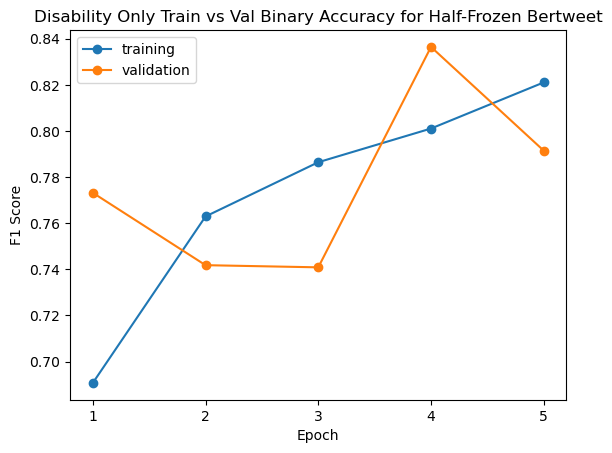

In [29]:
history = pd.DataFrame(disability_history.history)
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.title('Disability Only Train vs Val Binary Accuracy for Half-Frozen Bertweet')
plt.xticks([0, 1, 2, 3, 4],['1', '2', '3', '4', '5'])
plt.plot(history['binary_accuracy'], label="training", marker='o')
plt.plot(history['val_binary_accuracy'], label="validation", marker='o')
plt.legend()
plt.show()

## Evaluate Disability Model on Test Set

In [30]:
disability_test_history = disability_model.evaluate(bertweet_test_inputs_disability, y_test_disability)

117/117 [==============================] - 45s 379ms/step - loss: 0.4699 - binary_accuracy: 0.7924 - precision: 0.4931 - recall: 0.8494 - f1_score: 0.6240


## Export Results to csv

In [35]:
disability_test_history_df = pd.DataFrame({
    'test_loss': disability_test_history[0],
    'test_binary_accuracy': disability_test_history[1],
    'test_precision': disability_test_history[2],
    'test_recall': disability_test_history[3],
    'test_f1_score': disability_test_history[4]})
disability_results_df = pd.concat([pd.DataFrame(disability_history.history), disability_test_history_df], axis=0)
disability_results_df

,loss,binary_accuracy,precision,recall,f1_score,val_loss,val_binary_accuracy,val_precision,val_recall,val_f1_score,test_loss,test_binary_accuracy,test_precision,test_recall,test_f1_score
0,0.574286,0.690733,0.381563,0.700870,[0.4941207],0.493458,0.773196,0.478316,0.833333,[0.6077796],NaN,NaN,NaN,NaN,NaN
1,0.485123,0.762932,0.468565,0.745830,[0.5755456],0.548597,0.741799,0.444322,0.895556,[0.5939573],NaN,NaN,NaN,NaN,NaN
2,0.444014,0.786451,0.502925,0.779188,[0.6112929],0.541670,0.740862,0.444324,0.913333,[0.59781826],NaN,NaN,NaN,NaN,NaN
3,0.412935,0.801063,0.525154,0.802393,[0.634825],0.360841,0.836457,0.583748,0.782222,[0.6685661],NaN,NaN,NaN,NaN,NaN
4,0.388453,0.821066,0.558065,0.815446,[0.66264],0.476232,0.791471,0.503161,0.884444,[0.6414183],NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.469923,0.792392,0.493098,0.849406,0.623969


In [36]:
disability_results_df.to_csv('experiment_results/disability_only_half-frozen_take1.csv')

# Save Model Weights

In [37]:
disability_model.save_weights('saved_weights/take1_disability_only_half_frozen.h5')